# Certamen de Simulación Estocástica - Pregunta 1
- Diego Astaburuaga

Considerando matrices simétricas de dimensión $p\times p$ con valores propios positivos, notamos que se busca simular desde la distribución de Wishart.

En efecto, la distribución de Wishart es una familia de distribuciones para matrices simetricas definidas positivas.

Sean $Z_1,...,Z_k$ independientes desde una distribución $N_p(0,\Sigma)$, entonces escriba la matriz $Z=[Z_1,...,Z_k]$ de dimensión $p\times k$. La matriz de dimensión $p\times p$ aleatoria $X=ZZ^T=\sum_{i=1}^kZ_iZ_i^T$ se dice que sigue una distribución de Wishart.

**Definición 1.** La matriz aleatoria $X_{(p\times p)}=\sum_{i=1}^kZ_iZ^T_i$ tiene una distribución de Wishart con $k$ grados de libertad y matriz de covarianza $\Sigma$ y se denota $X\sim W_p(n,\Sigma)$. Para $k> p-1$ la densidad de probabilidad de $M$ está dada por
$$
f(X)=\frac{\det(X)^{(k-p-1)/2}}{2^{kp/2}\Gamma_p(k/2)\det(\Sigma)^{k/2}}\exp\left(-\frac{1}{2} Tr(\Sigma^{-1}X)\right)
$$
para $X$ en las matrices simetricas definidas positivas.

Note que la notación para la matriz $V=\Sigma$ es consistente al ser una matriz de covarianza, ya que siempre puede ser tomada como simetrica y definida positiva (basta con no utilizar aquellas singulares).

## 1) Método de simulación.

> No debe ser lo que espera el profe, ya que la pregunta 2 claramente tiene que ver con el método utilizado.

Se escoje el método de simulación directo que surge de utilizar la definición de la distribución que se está considerando, esto es:

i) Fijar $\Sigma$ matriz $p\times p$ simetrica y definida positiva.

ii) Simular de forma independiente $Z_1,...,Z_k$ desde una distribución $N_p(0,\Sigma)$.

iii) Calcular $X=\sum_{i=1}^kZ_iZ_i^T$.

> Puedo mantener esto por mientras y si tengo tiempo editarlo, el resto del código debería ser invariante.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [32]:
def generate_covariance_matrix(p=1):
    """
    Generate a covariance matrix Sigma of size pxp.

    Args:
    p (int): Dimension of the matrix.

    Returns:
    numpy.ndarray: Covariance matrix Sigma.
    """
    # Generate a random p x p matrix with values between 0 and 1
    random_matrix = np.random.rand(p, p)

    # Calculate the covariance matrix
    covariance_matrix = np.dot(random_matrix, random_matrix.T)

    return covariance_matrix

# Example of usage
p_dimension = 3  # Replace with the desired dimension
cov_matrix = generate_covariance_matrix(p_dimension)
print("Covariance Matrix Sigma:")
print(cov_matrix)

Covariance Matrix Sigma:
[[0.0238614  0.10966976 0.04107235]
 [0.10966976 0.58069349 0.27031692]
 [0.04107235 0.27031692 0.18061848]]


In [33]:
def simulate_multivariate_normal(p=1, k=1, Sigma=None):
    """
    Simulate k random vectors from a multivariate normal distribution.

    Args:
    p (int): Dimension of the random vectors.
    k (int): Number of random vectors to simulate.
    Sigma (numpy.ndarray, optional): Covariance matrix. If not provided, defaults to the identity matrix.

    Returns:
    numpy.ndarray: Array of shape (k, p) containing the simulated random vectors.
    """
    if Sigma is None:
        Sigma = np.identity(p)

    # Generate k random vectors from the multivariate normal distribution
    random_vectors = np.random.multivariate_normal(np.zeros(p), Sigma, size=k)

    return random_vectors

# Example of usage
p_dimension = 3  # Dimension of the random vectors
num_vectors = 5  # Number of random vectors to simulate

# Simulate random vectors with a custom covariance matrix
custom_covariance = generate_covariance_matrix(p_dimension)
simulated_data_custom = simulate_multivariate_normal(p_dimension, num_vectors, Sigma=custom_covariance)
print("Simulated Data with Custom Covariance:")
print(simulated_data_custom)

Simulated Data with Custom Covariance:
[[-2.22392636e-04  2.81975609e-01  2.75487705e-01]
 [ 6.72282042e-01  1.07639565e+00  1.53085190e+00]
 [ 7.18434589e-01  1.33095877e+00  1.01230388e+00]
 [-2.03464715e-01 -8.28719158e-01 -1.24491551e+00]
 [ 9.48399216e-01 -5.09246332e-01  9.31515869e-02]]


Notese que, por la forma que se construye la matriz, debemos usar el calculo:
$$
X = Z^TZ =\sum_{i=1}^kZ_i^TZ_i
$$

In [34]:
def simulate_wishart_distribution(p, k, Sigma=None):
    if Sigma is None:
        Sigma = np.identity(p)

    Z = simulate_multivariate_normal(p=p, k=k, Sigma=Sigma)

    return Z.T @ Z

# Example of usage
p_dimension = 3  # Dimension of the random vectors
num_vectors = 5  # Number of random vectors to simulate

# Simulate random vectors with a custom covariance matrix
custom_covariance = generate_covariance_matrix(p_dimension)
simulated_data_custom = simulate_wishart_distribution(p_dimension, num_vectors, Sigma=custom_covariance)
print("Simulated Data wfrom wishart distribution:")
print(simulated_data_custom)

Simulated Data wfrom wishart distribution:
[[4.92110686 6.81276334 3.85201321]
 [6.81276334 9.92822896 5.67392277]
 [3.85201321 5.67392277 3.25068616]]


## 2) Gráficos relacionados a los tiempos de simulación respecto a la dimensión $p$.

Para esto consideraremos distintos valores de $p$ y de $k$, además, para obtener un valor representativo e independiente de la selección de la matriz $\Sigma$, se producirán distinas simulaciones para los mismos valores de $p$ y $k$ y se calculará el promedio.

In [35]:
# Crear una lista de valores de p desde 1 hasta 9
p_list = np.arange(1, 300, 10)

# Crear una lista de valores de k desde 0 hasta 4
k_list = np.arange(0, 21, 5)

# Número de iteraciones para cada valor de p y k
n_itr = 100

# Diccionario para almacenar los tiempos de ejecución
time_by_p = {}

# Iterar a través de los valores de p en p_list
for p in p_list:
    time_by_k = {}  # Diccionario para los tiempos de ejecución por valor de k

    # Iterar a través de los valores de k en k_list
    for k in k_list:
        elapsed_times = []  # Lista para almacenar los tiempos de ejecución

        # Iniciar el contador de tiempo
        start_time = time.time()

        # Realizar n_itr simulaciones de Wishart para el valor actual de p y p+k
        for _ in range(n_itr):
            # Generar una matriz de covarianza Sigma para p
            Sigma = generate_covariance_matrix(p) 
            simulate_wishart_distribution(p, p + k, Sigma)

        # Detener el contador de tiempo y calcular el tiempo transcurrido
        end_time = time.time()
        elapsed_time = end_time - start_time

        elapsed_times.append(elapsed_time/n_itr)  # Agregar el tiempo transcurrido a la lista
        time_by_k[k] = elapsed_times  # Almacenar en el diccionario de tiempos por valor de k

    time_by_p[p] = time_by_k  # Almacenar en el diccionario de tiempos por valor de p

# El diccionario time_by_p ahora contiene los tiempos de ejecución para diferentes valores de p y k

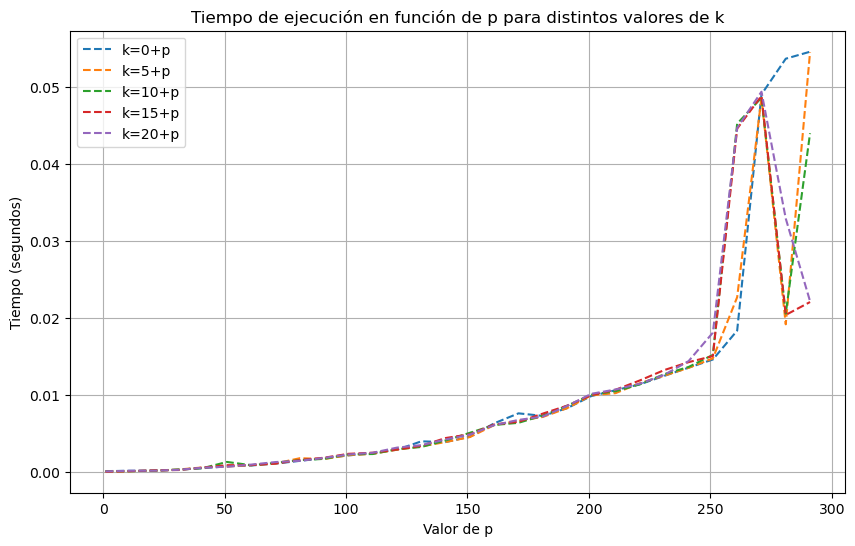

In [36]:
# Crear el gráfico de tiempo vs. p para distintos valores de k
plt.figure(figsize=(10, 6))

for k in k_list:
    times = [time_by_p[p][k][0] for p in p_list]
    plt.plot(p_list, times, '--', label=f'k={k}+p')

plt.xlabel('Valor de p')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de ejecución en función de p para distintos valores de k')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

Como es de esperarse, a mayor $p$ el tiempo de computo aumenta, lo que es interesante, es que el valor de $k$ no juega un rol crucial en el tiempo de computo. Por otro lado, en el procedimiento anterior puede ser posible que la generación de la matriz $\Sigma$ pueda afectar el tiempo de computo, veamos que este no es significativo mediante lo siguiente.

In [54]:
# Definir tus funciones generate_covariance_matrix y simulate_wishart_distribution aquí

# Crear una lista de valores de p desde 1 hasta 9
p_list = np.arange(1, 300, 10)

# Número de iteraciones para cada valor de p y k
n_itr = 500

# Iterar a través de los valores de p en p_list
elapsed_times = []  # Lista para almacenar los tiempos de ejecución
for p in p_list:

    # Iniciar el contador de tiempo
    start_time = time.time()

    # Realizar n_itr simulaciones de Wishart para el valor actual de p y p+k
    for _ in range(n_itr):
        # Generar una matriz de covarianza Sigma para p
        generate_covariance_matrix(p) 

    # Detener el contador de tiempo y calcular el tiempo transcurrido
    end_time = time.time()
    elapsed_time = end_time - start_time

    elapsed_times.append(elapsed_time/n_itr)  # Agregar el tiempo transcurrido a la lista

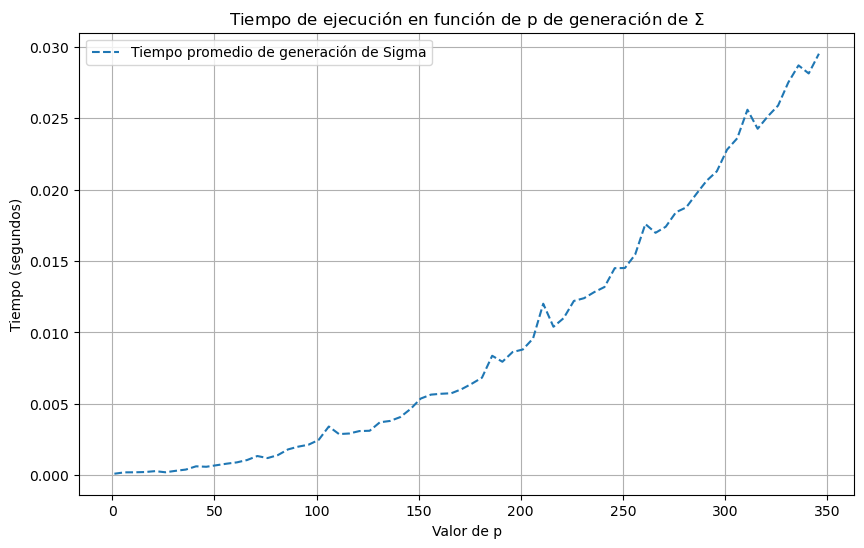

In [90]:
plt.figure(figsize=(10, 6))

plt.plot(p_list, elapsed_times, '--', label=f'Tiempo promedio de generación de Sigma')


plt.xlabel('Valor de p')
plt.ylabel('Tiempo (segundos)')
plt.title(r'Tiempo de ejecución en función de p de generación de $\Sigma$')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

De donde se deduce que efectivamente no es significativo. Tratemos de entender como crece el tiempo de computo, para esto busquemos ajustar un modelo cuadrático asociado al tamaño de la matriz y un modelo exponencial, el cual que indicaría que el algoritmo no es estable en tiempos de computo para valores altos.

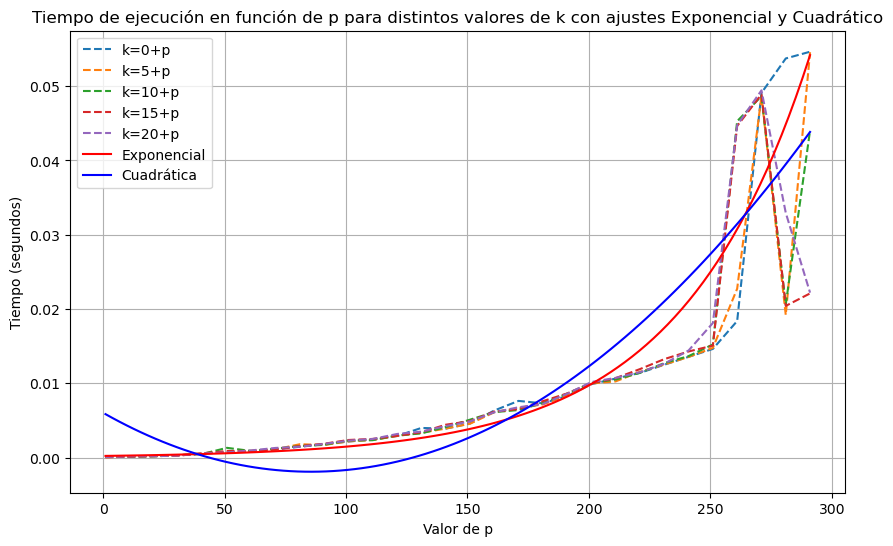

In [56]:
# Crear el gráfico de tiempo vs. p para distintos valores de k
plt.figure(figsize=(10, 6))

for k in k_list:
    times = [time_by_p[p][k][0] for p in p_list]
    plt.plot(p_list, times, '--', label=f'k={k}+p')

# Ajustar una función exponencial para k=0
k_fit = 0
times_fit = [time_by_p[p][k_fit][0] for p in p_list]
params_exp, covariance_exp = np.polyfit(p_list, np.log(times_fit), 1, cov=True)
A_exp = np.exp(params_exp[1])
B_exp = params_exp[0]
fit_label_exp = f'Exponencial'

# Ajustar una función cuadrática para k=0
params_quad = np.polyfit(p_list, times_fit, 2)
A_quad = params_quad[0]
B_quad = params_quad[1]
C_quad = params_quad[2]
fit_label_quad = f'Cuadrática'

# Calcular las funciones ajustadas
p_values = np.linspace(min(p_list), max(p_list), 100)
times_exponential = A_exp * np.exp(B_exp * p_values)
times_quadratic = A_quad * p_values**2 + B_quad * p_values + C_quad

# Dibujar las funciones ajustadas
plt.plot(p_values, times_exponential, 'r-', label=fit_label_exp)
plt.plot(p_values, times_quadratic, 'b-', label=fit_label_quad)

plt.xlabel('Valor de p')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de ejecución en función de p para distintos valores de k con ajustes Exponencial y Cuadrático')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


De donde no queda claro si el tiempo crece de forma cuadrática o exponencial, a priori por los valores bajos de $p$, se afirma que el tiempo crece de forma exponencial, alcanzando inestabilidad cuando $p>250$.

In [85]:
# Definir tus funciones generate_covariance_matrix y simulate_wishart_distribution aquí

# Crear una lista de valores de p desde 1 hasta 9
p_list = np.arange(1, 350, 5)

# Número de iteraciones para obtener promedio
n_itr = 50

elapsed_times = []  # Lista para almacenar los tiempos de ejecución

# Iterar a través de los valores de p en p_list
for p in p_list:

    # Iniciar el contador de tiempo
    start_time = time.time()

    # Realizar n_itr simulaciones de Wishart para el valor actual de p y p+k
    for _ in range(n_itr):
        # Generar una matriz de covarianza Sigma para p
        Sigma = generate_covariance_matrix(p) 
        simulate_wishart_distribution(p, p + k, Sigma)

    # Detener el contador de tiempo y calcular el tiempo transcurrido
    end_time = time.time()
    elapsed_time = end_time - start_time

    elapsed_times.append(elapsed_time/n_itr)  # Agregar el tiempo transcurrido a la lista

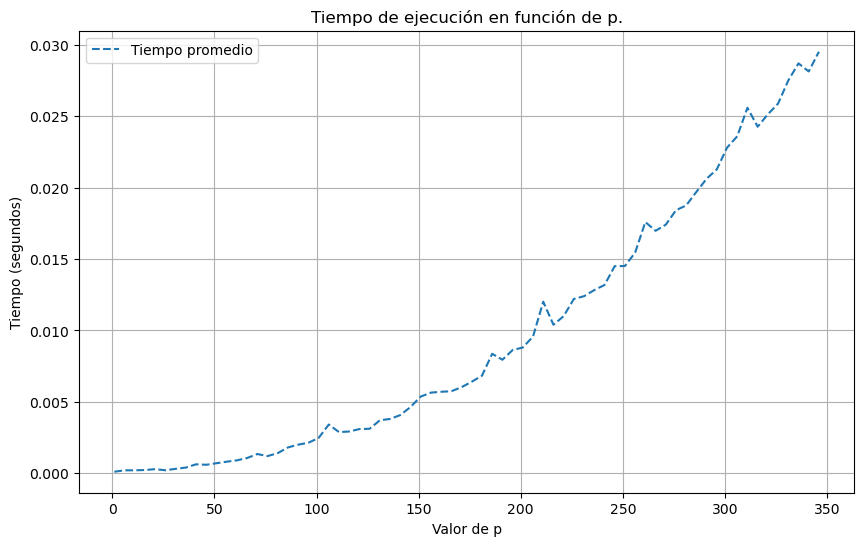

In [89]:
plt.figure(figsize=(10, 6))

plt.plot(p_list, elapsed_times, '--', label=f'Tiempo promedio')


plt.xlabel('Valor de p')
plt.ylabel('Tiempo (segundos)')
plt.title(r'Tiempo de ejecución en función de p.')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

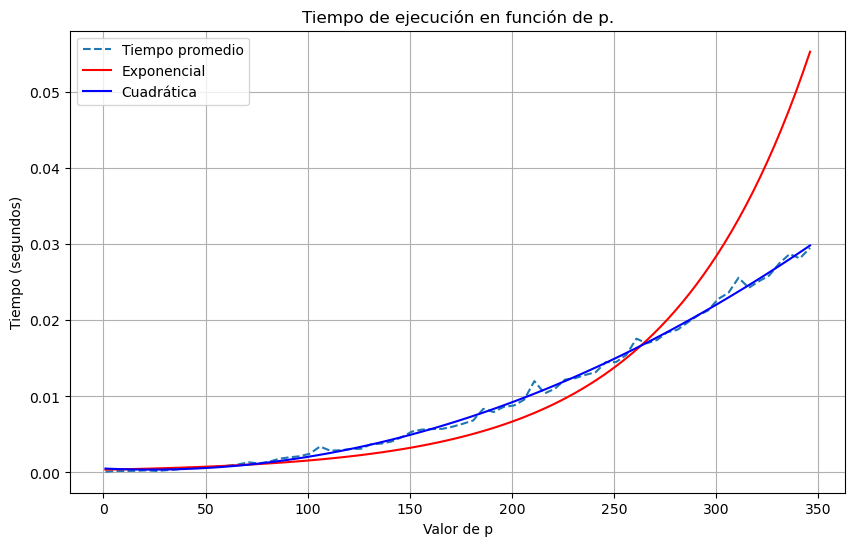

In [88]:
plt.figure(figsize=(10, 6))

plt.plot(p_list, elapsed_times, '--', label=f'Tiempo promedio')

# Ajustar una función exponencial para k=0
k_fit = 0
times_fit = elapsed_times
params_exp, covariance_exp = np.polyfit(p_list, np.log(times_fit), 1, cov=True)
A_exp = np.exp(params_exp[1])
B_exp = params_exp[0]
fit_label_exp = f'Exponencial'

# Ajustar una función cuadrática para k=0
params_quad = np.polyfit(p_list, times_fit, 2)
A_quad = params_quad[0]
B_quad = params_quad[1]
C_quad = params_quad[2]
fit_label_quad = f'Cuadrática'

# Calcular las funciones ajustadas
p_values = np.linspace(min(p_list), max(p_list), 100)
times_exponential = A_exp * np.exp(B_exp * p_values)
times_quadratic = A_quad * p_values**2 + B_quad * p_values + C_quad

# Dibujar las funciones ajustadas
plt.plot(p_values, times_exponential, 'r-', label=fit_label_exp)
plt.plot(p_values, times_quadratic, 'b-', label=fit_label_quad)

plt.xlabel('Valor de p')
plt.ylabel('Tiempo (segundos)')
plt.title(r'Tiempo de ejecución en función de p.')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

de donde queda mucho más claro que el tiempo crece de forma cuádratica.

## 3) Comprobación de que el método funciona.

> Hay que utilizar la **Obs 3:** y verificar que: $E[X]=k\Sigma$, que para $X_{ij}$ y $\sigma_{ij}$ las entradas $(i,j)$ de las matrices $X$ y $\Sigma$ respectivamente, se tiene que $Var(X_{ij})=k(v_{ij}^2+\sigma_{ii}\sigma_{jj})$. Por \'ultimo bastaria verificar que $X_{ii}\sim \sigma_{ii}\chi_{k}^2$

### Verificación del promedio.

Considere el estimador insesgado de $E[X]=k\Sigma$ como
$$
T(\underline{X})=\overline{X}
$$

Luego utilizaremos la distancia de Frobenius para determinar que tan cercana es nuestra estimación del valor real, si esta es cercana a 0, tenemos razones experimentales para determinar que la simulación funciona correctamente. La distancia de Frobenius se determina en base a su norma:
$$
||A||_F:=\left(tr(A^TA)\right)^{1/2}
$$

In [93]:
# Crear una lista de valores de p
p_list = np.arange(5, 26, 5)  # Puedes ajustar esta lista según los valores de p deseados

n_itr = 1_000

# Lista de valores de k
p = np.max(p_list)
k_list = np.arange(p, p + 201, 10)

# Diccionario para almacenar las distancias de Frobenius para diferentes valores de p
frobenius_distances = {p_val: [] for p_val in p_list}

# Iterar a través de los valores de p en la lista
for p in p_list:
    Sigma = generate_covariance_matrix(p)  # Generar matriz de covarianza para el valor de p actual

    for k in k_list:
        T = np.zeros((p, p))

        # Realizar n_itr simulaciones y promediar
        for _ in range(n_itr):
            T += simulate_wishart_distribution(p, k, Sigma)  # Asegúrate de tener esta función definida

        # Calcular la distancia de Frobenius entre k * Sigma y el promedio
        frobenius_distances[p].append(np.linalg.norm(k * Sigma - T / (n_itr)))

# Ahora tienes un diccionario de distancias de Frobenius para cada valor de p en p_list
# Puedes utilizar estos datos para análisis o visualización

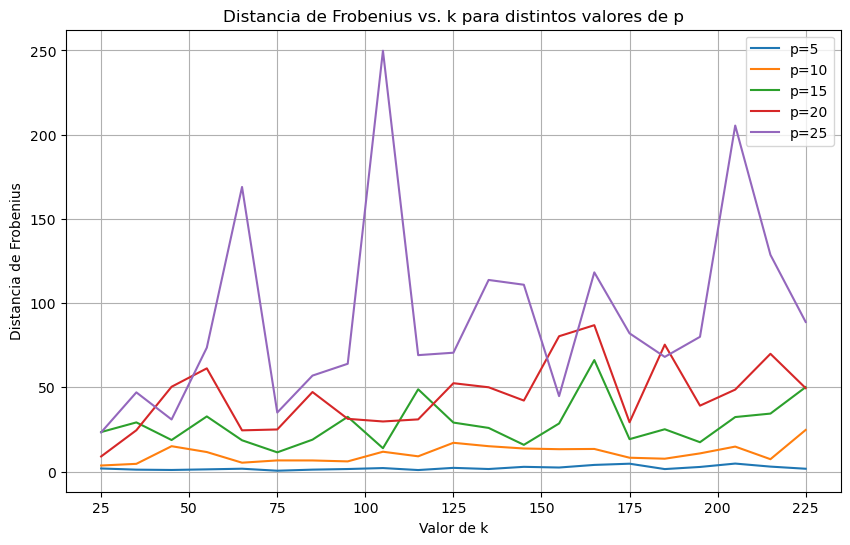

In [94]:
# Crear el gráfico de distancia de Frobenius vs. k para distintos valores de p
plt.figure(figsize=(10, 6))

for p_val in p_list:
    distances = frobenius_distances[p_val]
    plt.plot(k_list, distances, label=f'p={p_val}')

plt.xlabel('Valor de k')
plt.ylabel('Distancia de Frobenius')
plt.title('Distancia de Frobenius vs. k para distintos valores de p')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

Utilizando $1000$ muestras desde la distribución, se puede mostrar que para dimensiones bajas (menores a 5), esto es suficiente para alcanzar una precisión deseada, pero para dimensiones mayores esto no es claro. Por otro lado se muestra que para distintos $k$, aparentemente, no esto afecta al rendimiento del cálculo.

Para verificar que efectivamente el estimador converge a la esperanza, realizaremos pruebas de simulación y estudiaremos el número de muestras necesarias para alcanzar una precisión deseada.

In [95]:
import numpy as np

def calculate_iterations_to_tolerance(n_max=100_000, p=1, k=None, tol=0.1, max_iterations_without_decrease=None):
    if max_iterations_without_decrease==None:
        max_iterations_without_decrease = n_max/10

    if k==None:
        k = p

    # Valores fijos de p y k
    Sigma = generate_covariance_matrix(p)

    # Inicializar contador de iteraciones
    iterations = 0

    # Inicializar una matriz T para acumular resultados
    T = np.zeros((p, p))

    # Lista para almacenar las distancias calculadas en cada ciclo
    distances = []

    # Inicializar contador de iteraciones sin disminución
    iterations_without_decrease = 0

    # Distancia más baja registrada
    lowest_distance = np.inf

    # Bucle while para iterar hasta que la distancia sea menor que tol o se alcance el máximo de iteraciones
    while iterations < n_max:
        # Realizar una simulación de Wishart
        realization = simulate_wishart_distribution(p, k, Sigma)

        # Acumular el resultado en T
        T += realization

        # Calcular la distancia de Frobenius entre T y k * Sigma
        distance = np.linalg.norm(T / (iterations + 1) - k * Sigma)

        # Agregar la distancia calculada a la lista
        distances.append(distance)

        # Verificar si la distancia es menor que la tolerancia
        if distance < tol:
            break

        # Verificar si la distancia no ha disminuido
        if distance >= lowest_distance:
            iterations_without_decrease += 1
        else:
            iterations_without_decrease = 0

        # Si no hay disminución durante un número de iteraciones especificado, terminar
        if iterations_without_decrease >= max_iterations_without_decrease:
            break

        # Actualizar la distancia más baja registrada
        lowest_distance = min(lowest_distance, distance)

        # Incrementar el contador de iteraciones
        iterations += 1

    return iterations, distances, lowest_distance

# Parámetros
p = 5
k = 10
tol = 0.1

# Llamada a la función
iterations, distances, lowest_distance = calculate_iterations_to_tolerance(p=p, k=k, tol=tol)

# Imprimir el resultado
print(f"Con {iterations} iteraciones se logró alcanzar una distancia de {distances[-1]}")
print(f"La distancia más baja registrada fue {lowest_distance}")


Con 10243 iteraciones se logró alcanzar una distancia de 0.09972358339065066
La distancia más baja registrada fue 0.10000954915881946


In [96]:
# Array de valores de p que van desde 10 hasta 100 en incrementos de 10
p_array = np.arange(1, 25 + 1, 2)

# Número máximo de iteraciones para todas las simulaciones
n_max = 1e9

# Tolerancia
tol = 1

# Listas para almacenar resultados
iterations_array = []  # Almacenará el número de iteraciones para cada valor de p
problem_array = []  # Almacenará información sobre valores de p problemáticos

# Iterar a través de los valores de p en p_array
for p in p_array:
    # Llama a la función calculate_iterations_to_tolerance
    iterations, distances, lowest_distance = calculate_iterations_to_tolerance(n_max=n_max, p=p, tol=tol)
    print(f'Listo {p=} con iteraciones {iterations=} y distance {distances[-1]}')
    
    # Si no se alcanza la tolerancia en el número máximo de iteraciones, se considera un problema
    if distances[-1]>tol:
        iterations_array.append(0)  # Agrega 0 a la lista de iteraciones (problema)
        problem_array.append([p, distances[-1]])  # Almacena información sobre el problema
    else:
        iterations_array.append(iterations)  # Agrega el número de iteraciones a la lista

# Al finalizar el bucle, tendrás dos listas:
# iterations_array con el número de iteraciones para cada valor de p (o 0 si hubo un problema).
# problem_array con información sobre los valores de p problemáticos que no alcanzaron la tolerancia en el número máximo de iteraciones.

Listo p=1 con iteraciones iterations=0 y distance 0.872226415481199
Listo p=3 con iteraciones iterations=2 y distance 0.40427397024382705
Listo p=5 con iteraciones iterations=98 y distance 0.8576454497393544
Listo p=7 con iteraciones iterations=1296 y distance 0.9578327253047104
Listo p=9 con iteraciones iterations=1801 y distance 0.9971753246146675
Listo p=11 con iteraciones iterations=10406 y distance 0.9970692266930319
Listo p=13 con iteraciones iterations=9772 y distance 0.9978968316288875
Listo p=15 con iteraciones iterations=45729 y distance 0.9980800851987667
Listo p=17 con iteraciones iterations=54571 y distance 0.999264293611087
Listo p=19 con iteraciones iterations=579493 y distance 0.9999179261578107
Listo p=21 con iteraciones iterations=114834 y distance 0.9982413598646934
Listo p=23 con iteraciones iterations=811135 y distance 0.9995643319109044
Listo p=25 con iteraciones iterations=757252 y distance 0.9999933463556215


Ahora considere el mismo procedimiento, pero considerando el promedio de iteraciones para varias simulaciones para cada $p$ con la finalidad de obtener una curva con menos varianza.

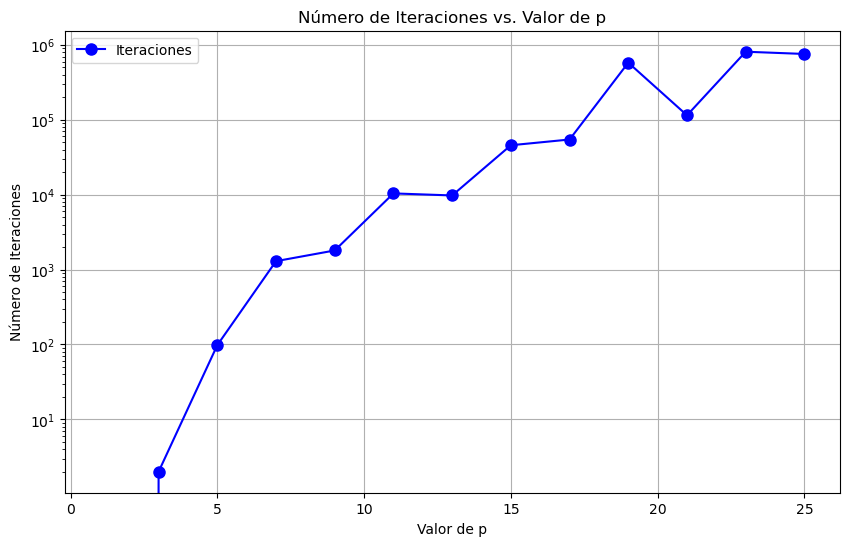

In [97]:
# Crear el gráfico
plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Personalizar el estilo de línea y los marcadores
plt.plot(p_array, iterations_array, marker='o', linestyle='-', color='b', markersize=8, label='Iteraciones')

plt.yscale('log')

# Etiquetas de ejes y título
plt.xlabel('Valor de p')
plt.ylabel('Número de Iteraciones')
plt.title('Número de Iteraciones vs. Valor de p')

# Mostrar una cuadrícula
plt.grid(True)

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


El número de iteraciones necesarias para llegar a la convergencia crece de manera muy rápida en función del $p$.

In [117]:
#iterations, distances, lowest_distance = calculate_iterations_to_tolerance(p=p, k=k, tol=tol)
p_list = [5,8,11,14,17]

distances_dic = {}

for p in p_list:
    distances_dic[p] = []

    for _ in range(3):
        iterations, distances, lowest_distance = calculate_iterations_to_tolerance(n_max=1_000_000, p=p, tol=1)
        distances_dic[p].append(distances)

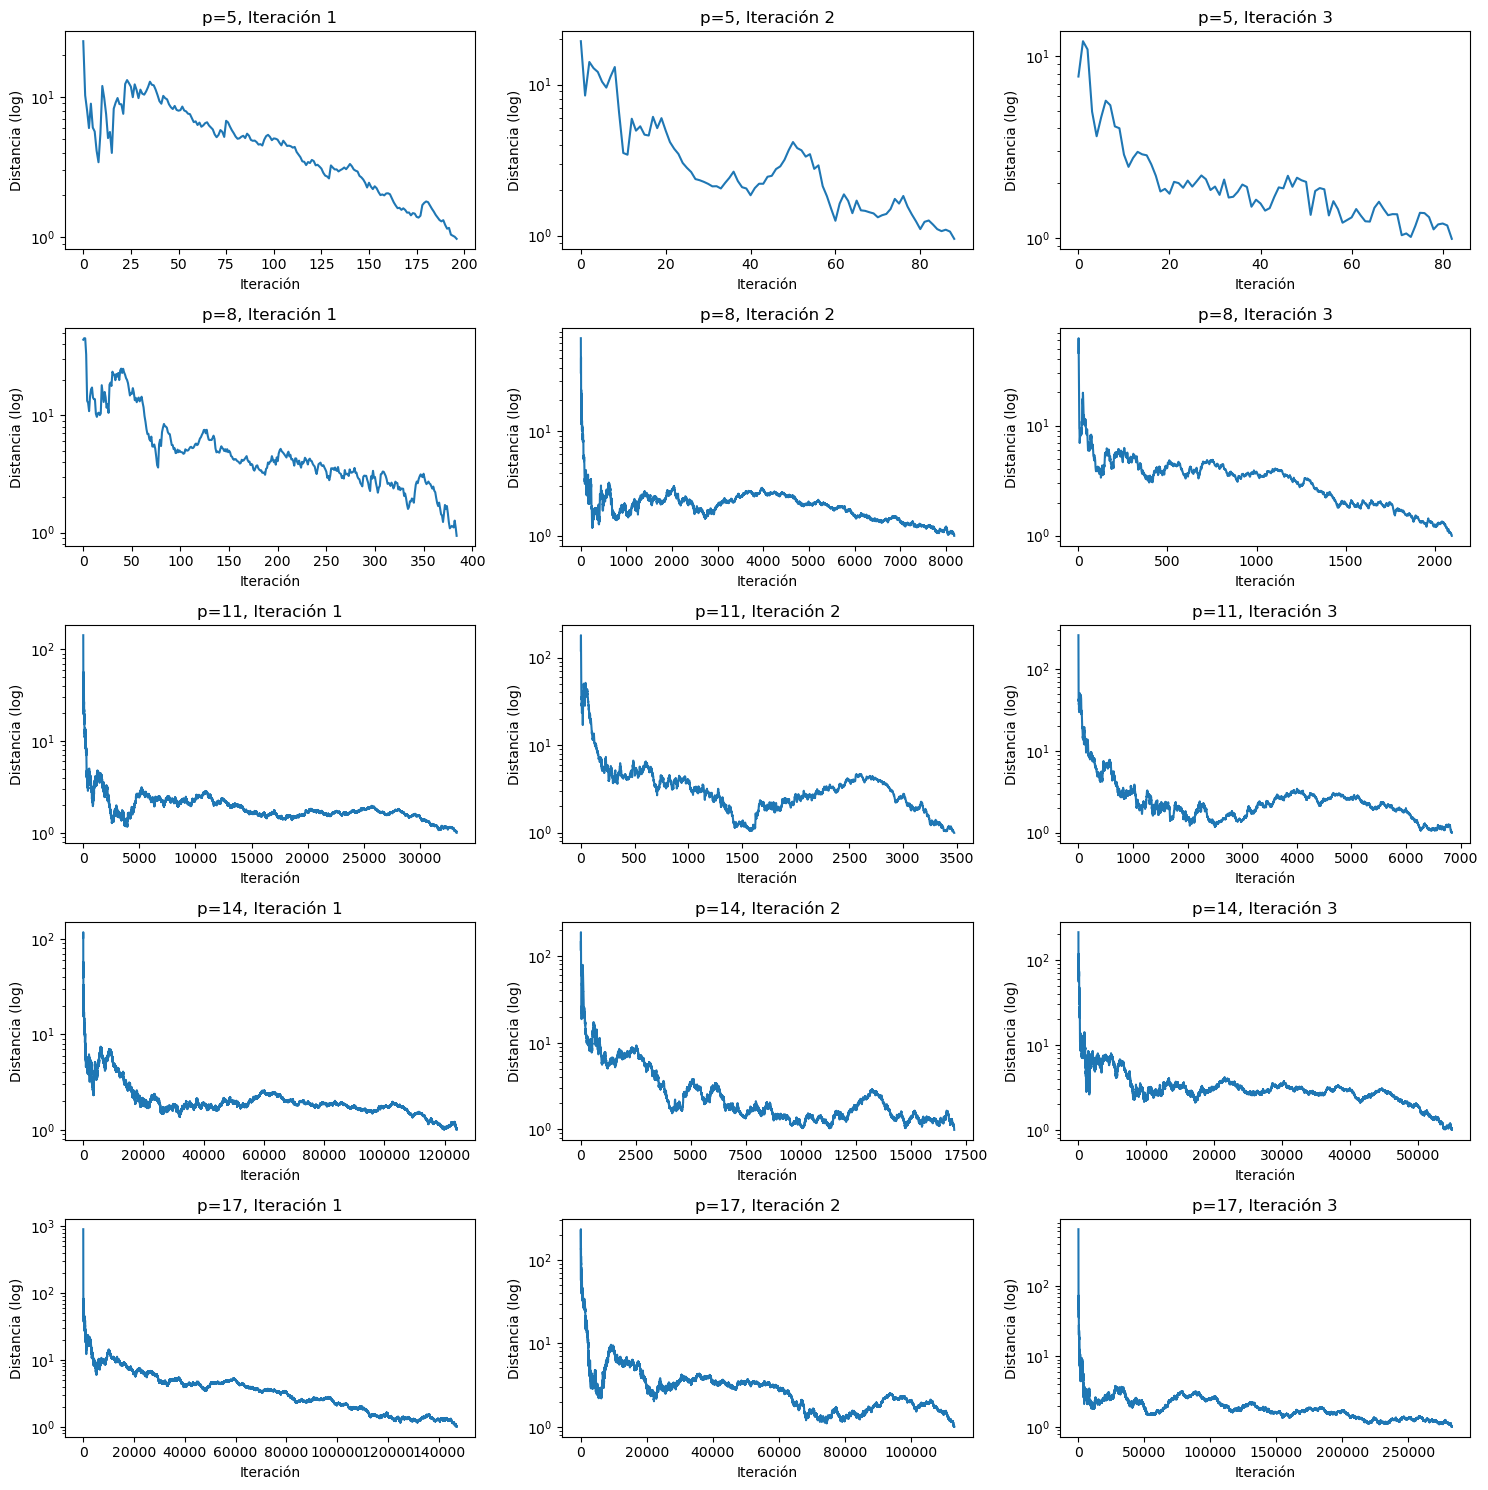

In [118]:
# Crear una grilla 5x3 para graficar
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

# Iterar a través de las filas y columnas de la grilla
for i, p in enumerate(p_list):
    for j in range(3):
        distances = distances_dic[p][j]  # Obtener las distancias correspondientes a p y la iteración j
        
        # Graficar las distancias en escala logarítmica
        axs[i, j].semilogy(np.arange(len(distances)), distances)
        axs[i, j].set_title(f'p={p}, Iteración {j+1}')
        axs[i, j].set_xlabel('Iteración')
        axs[i, j].set_ylabel('Distancia (log)')

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Realmente hay un problema al momento de querer aproximarse al promedio, pero tarde o temprano se termina logrando.

### Verificación de la varianza de la matriz y diagonal $\chi^2$.

> Haz la varianza de toda la matriz y comparala, pero hazlo componente a componente y suma los errores al cuadrado, la gracia es justamente la de estudiar componente a componente.
> Con respecto a la diagonal, como te dice que distribuye chi cuadrado, solamente comprueba que la esperanza ya la varianza son las mismas que de la distribución.

In [ ]:
# CODE!

## 4) El hardware utilizado.

>????
> Mi RAM computador,, la intelcore i7, etc?

## 5) Información que puede ser relevante.

> La información obtenida se encuentra en las clases de Felipe Osorio, también puede ser recomendable buscar otra bibliografía para citar.

> Que otras fuentes de simulación fueron barajeadas; Gibbs Sampling se rechazó directamente dado que no conocemos las condicionales y estás son muchas, Metropolis Hasting jugó un rol importante...

## 6) Simulando para $\lambda_i\in[0,\lambda_{\max}]$

> Simplemente utilizar aceptación-rechazo y ver como se rechazan las cosas.